Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate, concatenate
from tqdm import tqdm
import pathlib
import datetime
from IPython import display
import os

Defining pre-processing fuctions

In [ ]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img


def split_image(image):
    w = tf.shape(image)[1]
    w = w // 2
    sketch_image = image[:, :w, :]
    colored_image = image[:, w:, :]
    sketch_image = tf.image.resize(sketch_image, (256, 256))
    colored_image = tf.image.resize(colored_image, (256, 256))
    return sketch_image, colored_image


def flip_image(image):
    return tf.image.flip_left_right(image)


def shuffle_image(sketch_image, colored_image):
    if tf.random.uniform(()) > 0.5:
        sketch_image = flip_image(sketch_image)
        colored_image = flip_image(colored_image)

    return sketch_image, colored_image

  
def normalize_image(sketch_image, colored_image):
    sketch_image = tf.cast(sketch_image, tf.float32)/127.5 - 1
    colored_image = tf.cast(colored_image, tf.float32)/127.5 - 1
    return sketch_image, colored_image
    

def load_image_train(image_path):
    image = read_image(image_path)
    sketch_image, colored_image = split_image(image)
    sketch_image, colored_image = shuffle_image(sketch_image, colored_image)
    sketch_image, colored_image = normalize_image(sketch_image, colored_image)
    return colored_image, sketch_image


def load_image_test(image_path):
    image = read_image(image_path)\

    sketch_image, colored_image = split_image(image)
    sketch_image, colored_image = normalize_image(sketch_image, colored_image)
    return colored_image, sketch_image

Training input pipeline

In [ ]:
train_path = '/content/drive/MyDrive/Datasets/anime sketch ds/train'
train_images_path = [os.path.join(train_path, image_name) for image_name in os.listdir(train_path)]
print(len(train_images_path))

14243


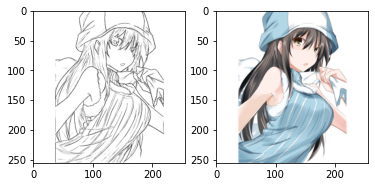

In [ ]:
BATCH_SIZE = 5
BUFFER_SIZE = 500

train_dataset = tf.data.Dataset.from_tensor_slices(train_images_path)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

for sketch, color in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(sketch[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(color[0]))

Testing input pipeline

In [ ]:
test_path = '/content/drive/MyDrive/Datasets/anime sketch ds/val'
test_images_path = [os.path.join(test_path, image_name) for image_name in os.listdir(test_path)]
print(len(test_images_path))

3545


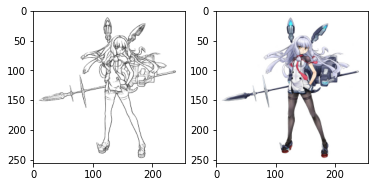

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images_path)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

for sketch, color in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(sketch[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(color[0]))

Pre-requisite functions for GAN Model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    block = Sequential()
    block.add(Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    if apply_batchnorm:
        block.add(BatchNormalization())
        
    block.add(LeakyReLU())
    return block


def upsample(filters, size, apply_dropout=False):
    block = Sequential()
    block.add(Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    block.add(BatchNormalization())
    if apply_dropout:
        block.add(Dropout(0.5))

    block.add(ReLU())
    return block

Discriminator model

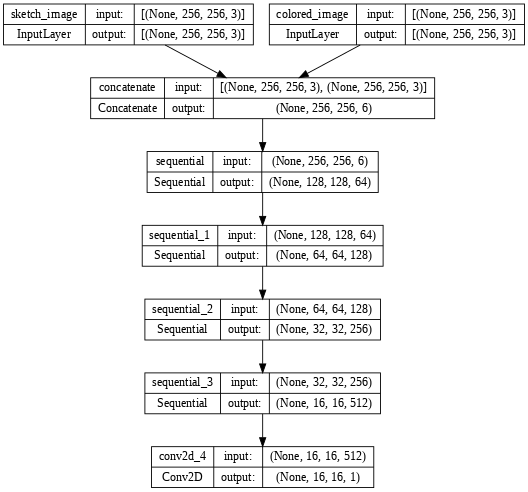

In [ ]:
def Discriminator():
    sketch_input = Input(shape=[256, 256, 3], name='sketch_image')
    target = Input(shape=[256, 256, 3], name='colored_image')
    x = concatenate([sketch_input, target])    
    block_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]
    
    last_layer = Conv2D(1, 4, strides=1, padding='same')
    
    for block in block_stack:
        x = block(x)
    
    x = last_layer(x)
    return Model(inputs=[sketch_input, target], outputs=x)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Generator model

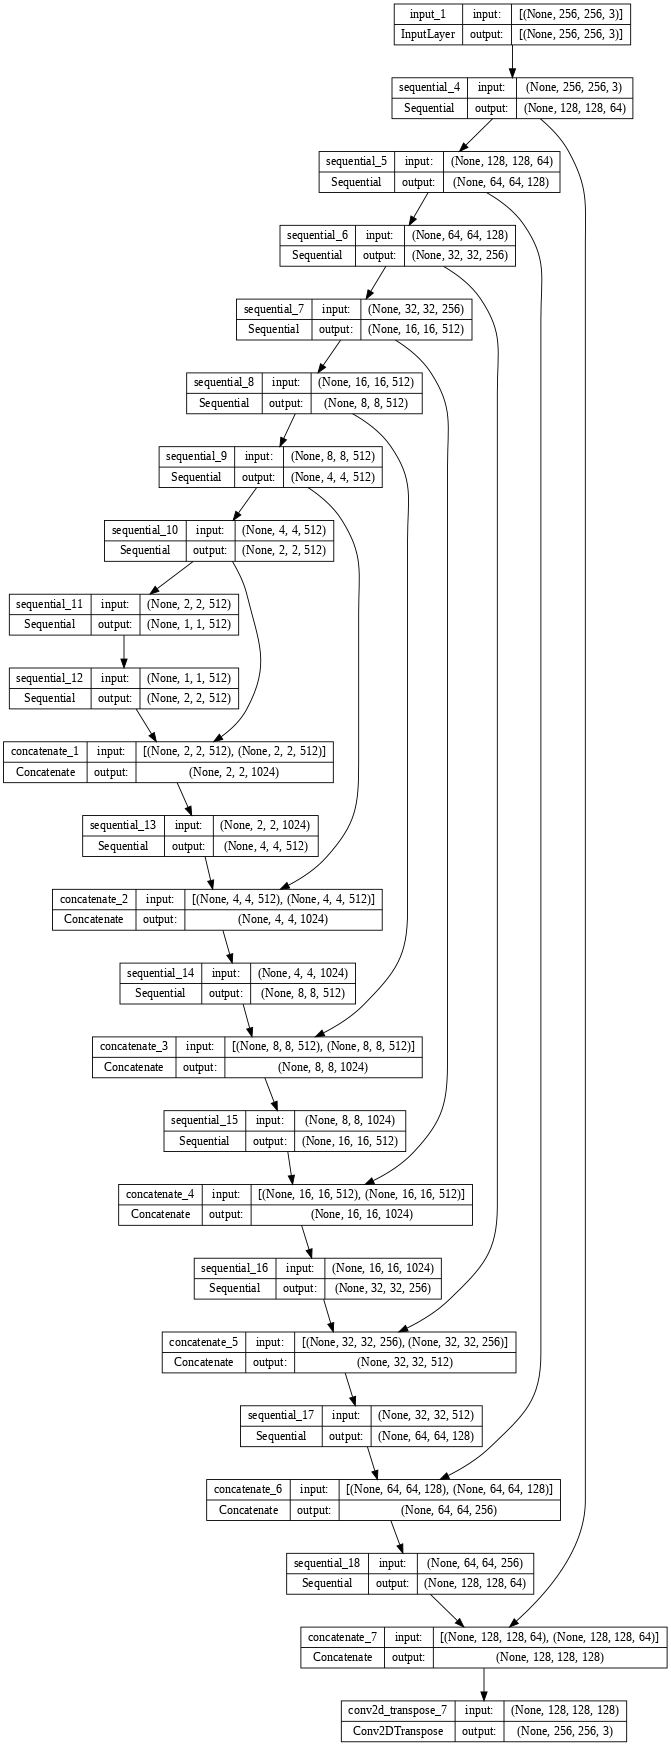

In [ ]:
OUTPUT_CHANNELS = 3
def Generator():
    generator_input = Input(shape=[256,256,3])
    x = generator_input
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    bottleneck = downsample(512, 4)
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    last_layer = Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh')
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    x = bottleneck(x)
    skips.reverse()

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last_layer(x)

    return Model(inputs=generator_input, outputs=x)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

D(x) & G(x) loss function

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lambda_value = 100

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)    
    return real_loss + generated_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (lambda_value * l1_loss)

Optimizing the model

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
epochs = 30
@tf.function
def train_step(sketch_image, ground_truth, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_output = generator(sketch_image, training=True)

        disc_real_output = discriminator([sketch_image, ground_truth], training=True)
        disc_generated_output = discriminator([sketch_image, generator_output], training=True)

        gen_loss = generator_loss(disc_generated_output, generator_output, ground_truth)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss
    

epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')


generator_mean_losses = []
discriminator_mean_losses = []

Image generation function

In [ ]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(16,16))

    plt.subplot(1, 3, 1)
    plt.title("Sketch Image")
    plt.imshow(test_input[0]*0.5+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Target Image")
    plt.imshow(target[0]*0.5+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Image")
    plt.imshow(prediction[0]*0.5+0.5)
    plt.axis('off')
    
    plt.show()

Model Training

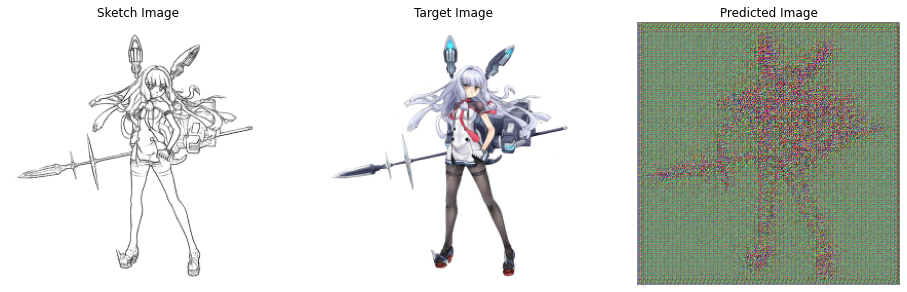

Epoch:  1


100%|██████████| 2849/2849 [02:35<00:00, 18.31it/s]



Generator Loss: 21.00
Discriminator Loss: 0.98



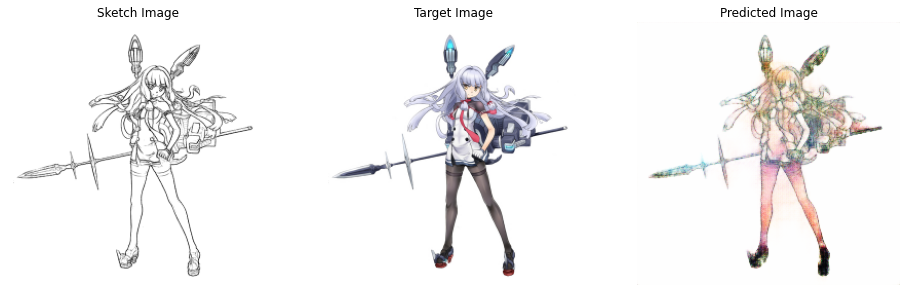

Epoch:  2


100%|██████████| 2849/2849 [01:25<00:00, 33.16it/s]



Generator Loss: 18.92
Discriminator Loss: 0.98



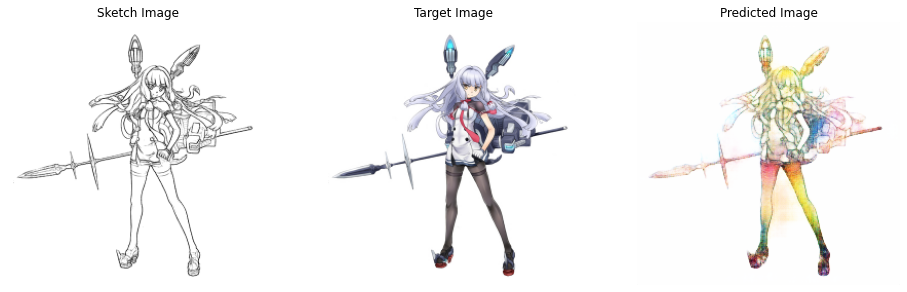

Epoch:  3


100%|██████████| 2849/2849 [01:26<00:00, 33.05it/s]



Generator Loss: 18.44
Discriminator Loss: 0.92



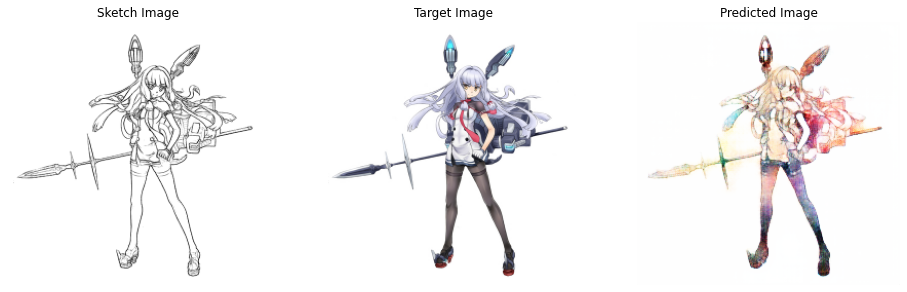

Epoch:  4


100%|██████████| 2849/2849 [01:26<00:00, 33.04it/s]



Generator Loss: 18.15
Discriminator Loss: 0.85



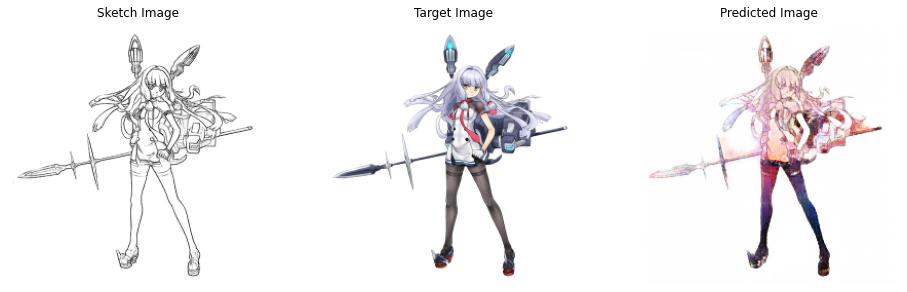

Epoch:  5


100%|██████████| 2849/2849 [01:26<00:00, 33.01it/s]



Generator Loss: 18.01
Discriminator Loss: 0.80



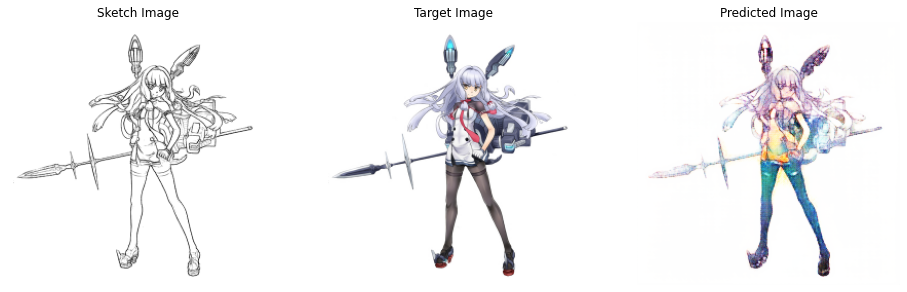

Epoch:  6


100%|██████████| 2849/2849 [01:26<00:00, 33.10it/s]



Generator Loss: 17.76
Discriminator Loss: 0.79



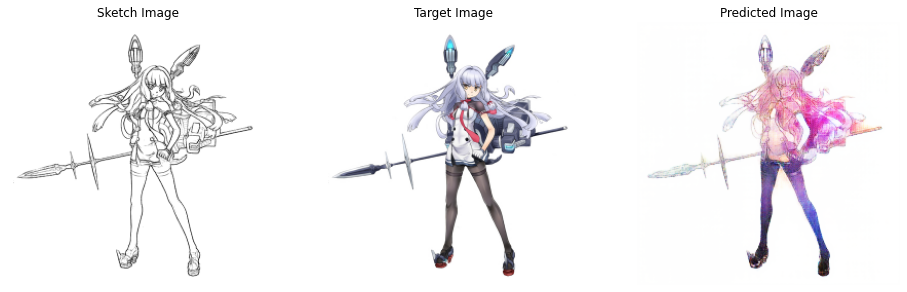

Epoch:  7


100%|██████████| 2849/2849 [01:26<00:00, 33.12it/s]



Generator Loss: 17.67
Discriminator Loss: 0.74



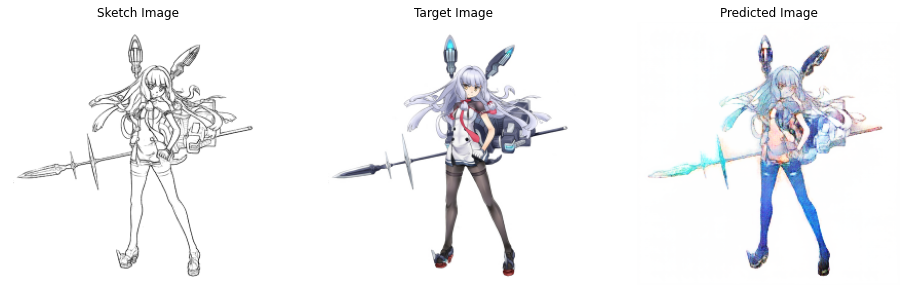

Epoch:  8


100%|██████████| 2849/2849 [01:26<00:00, 33.01it/s]



Generator Loss: 17.57
Discriminator Loss: 0.71



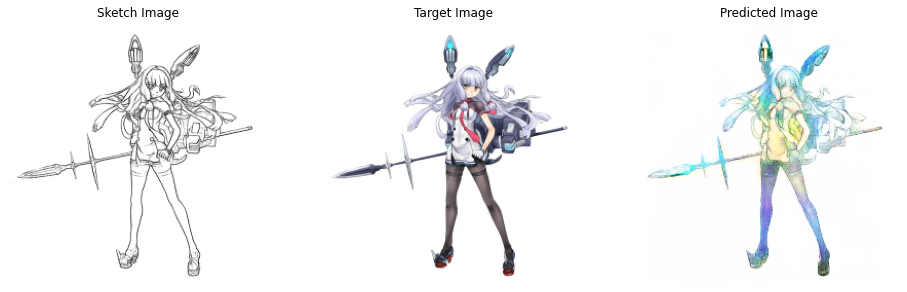

Epoch:  9


100%|██████████| 2849/2849 [01:25<00:00, 33.20it/s]



Generator Loss: 17.51
Discriminator Loss: 0.67



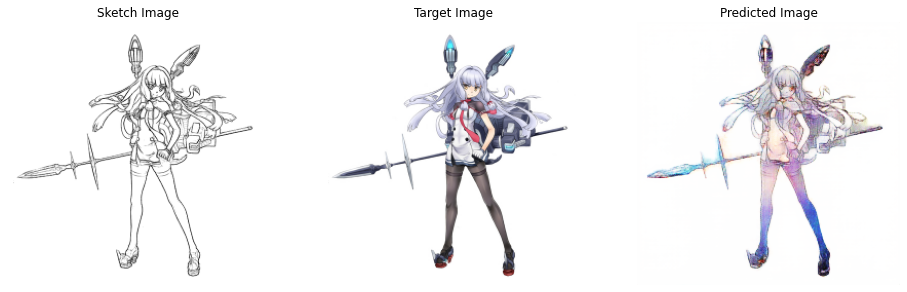

Epoch:  10


100%|██████████| 2849/2849 [01:25<00:00, 33.46it/s]



Generator Loss: 17.40
Discriminator Loss: 0.65



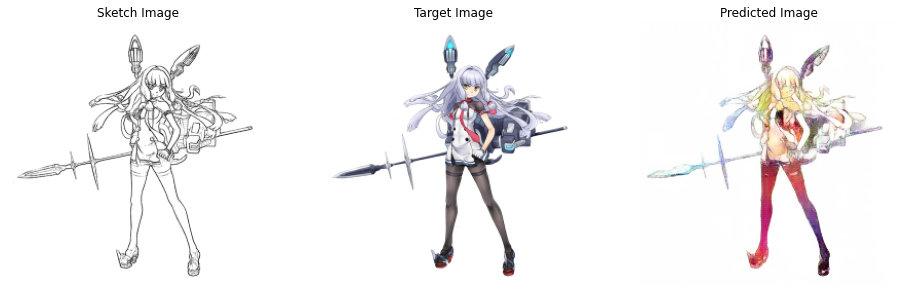

Epoch:  11


100%|██████████| 2849/2849 [01:26<00:00, 32.87it/s]



Generator Loss: 17.36
Discriminator Loss: 0.61



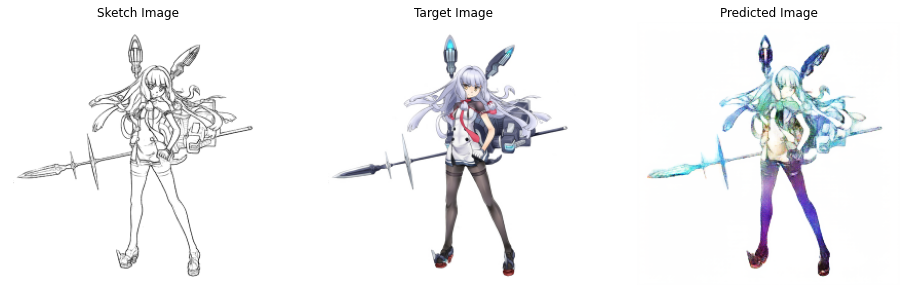

Epoch:  12


100%|██████████| 2849/2849 [01:26<00:00, 33.12it/s]



Generator Loss: 17.33
Discriminator Loss: 0.58



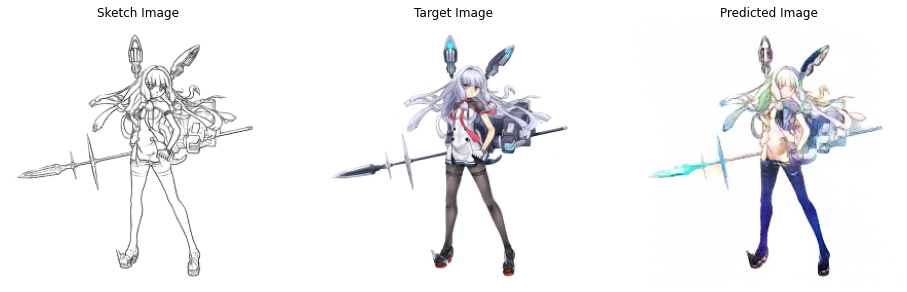

Epoch:  13


100%|██████████| 2849/2849 [01:24<00:00, 33.58it/s]



Generator Loss: 17.28
Discriminator Loss: 0.56



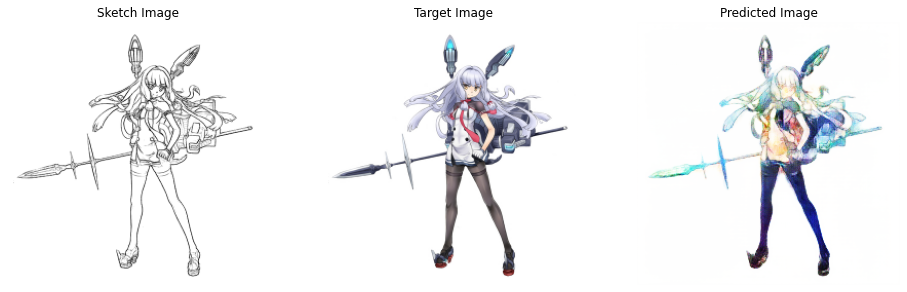

Epoch:  14


100%|██████████| 2849/2849 [01:26<00:00, 33.04it/s]



Generator Loss: 17.17
Discriminator Loss: 0.54



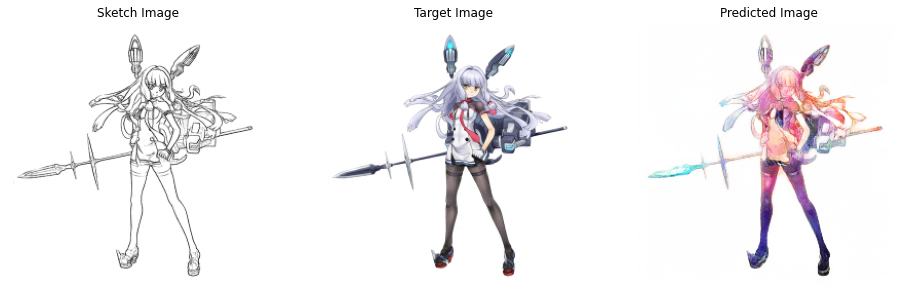

Epoch:  15


100%|██████████| 2849/2849 [01:25<00:00, 33.24it/s]



Generator Loss: 17.09
Discriminator Loss: 0.54



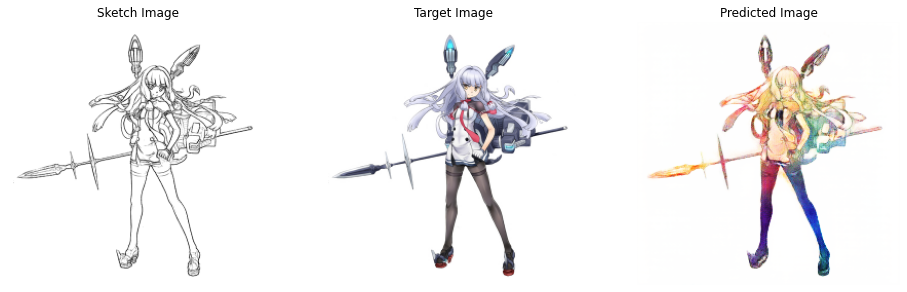

Epoch:  16


100%|██████████| 2849/2849 [01:26<00:00, 33.00it/s]



Generator Loss: 16.98
Discriminator Loss: 0.52



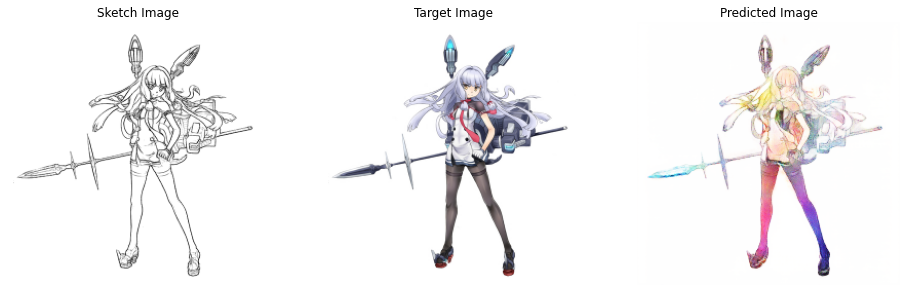

Epoch:  17


100%|██████████| 2849/2849 [01:26<00:00, 33.10it/s]



Generator Loss: 16.91
Discriminator Loss: 0.51



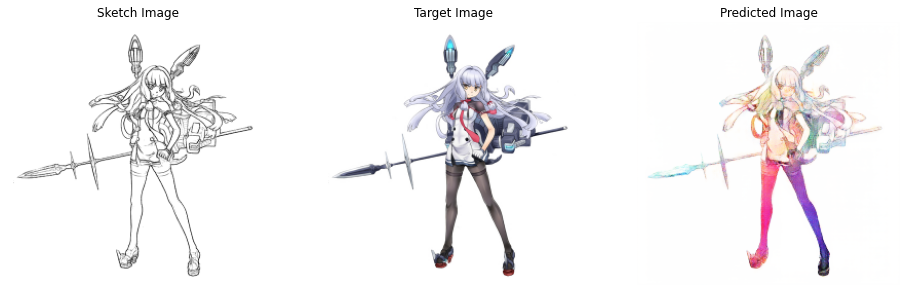

Epoch:  18


100%|██████████| 2849/2849 [01:26<00:00, 32.97it/s]



Generator Loss: 16.87
Discriminator Loss: 0.49



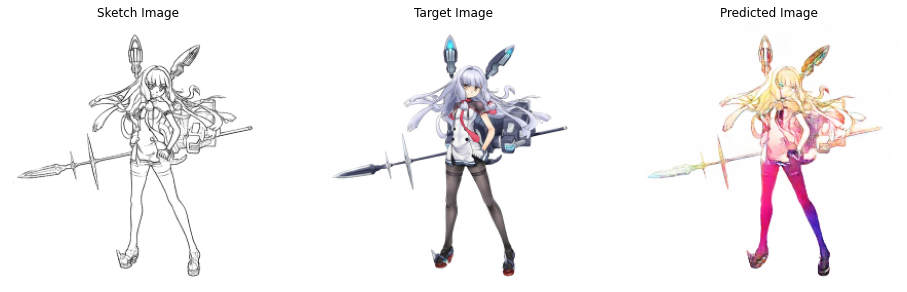

Epoch:  19


100%|██████████| 2849/2849 [01:25<00:00, 33.40it/s]



Generator Loss: 16.69
Discriminator Loss: 0.49



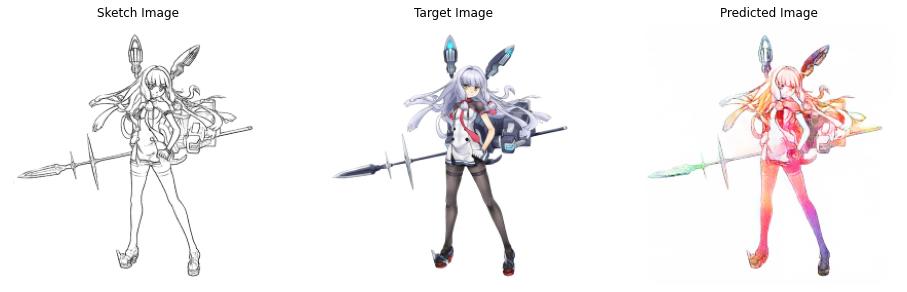

Epoch:  20


100%|██████████| 2849/2849 [01:25<00:00, 33.48it/s]



Generator Loss: 16.58
Discriminator Loss: 0.50



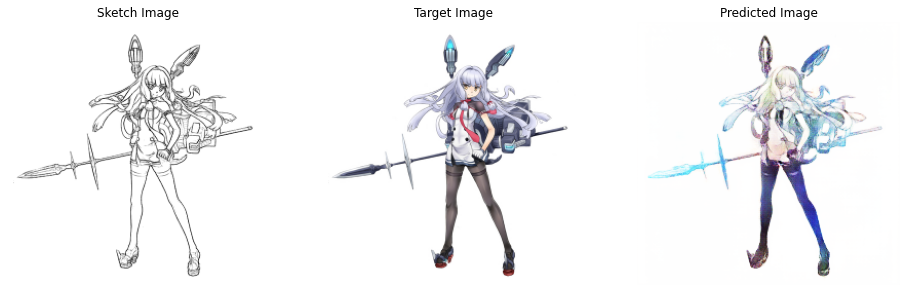

Epoch:  21


100%|██████████| 2849/2849 [01:26<00:00, 32.94it/s]



Generator Loss: 16.48
Discriminator Loss: 0.49



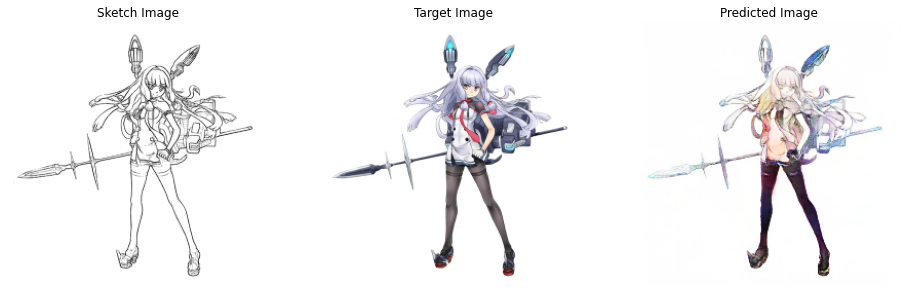

Epoch:  22


100%|██████████| 2849/2849 [01:26<00:00, 32.97it/s]



Generator Loss: 16.43
Discriminator Loss: 0.47



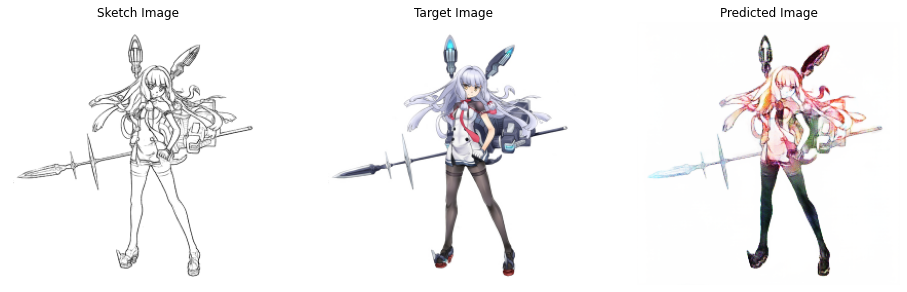

Epoch:  23


100%|██████████| 2849/2849 [01:26<00:00, 32.90it/s]



Generator Loss: 16.31
Discriminator Loss: 0.47



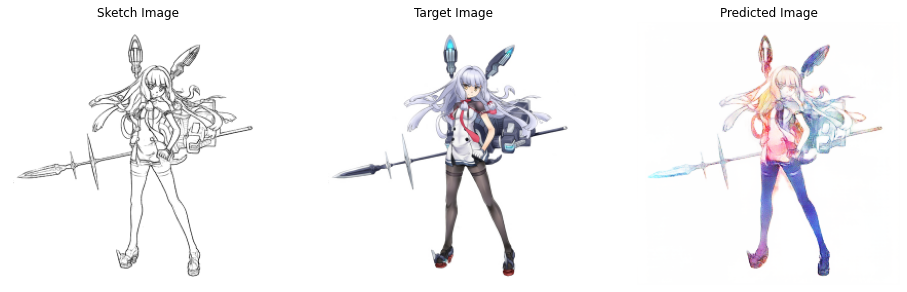

Epoch:  24


100%|██████████| 2849/2849 [01:26<00:00, 32.80it/s]



Generator Loss: 16.22
Discriminator Loss: 0.46



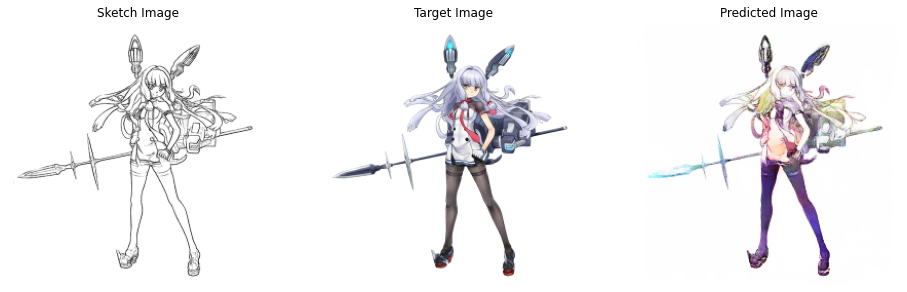

Epoch:  25


100%|██████████| 2849/2849 [01:27<00:00, 32.45it/s]



Generator Loss: 16.13
Discriminator Loss: 0.46



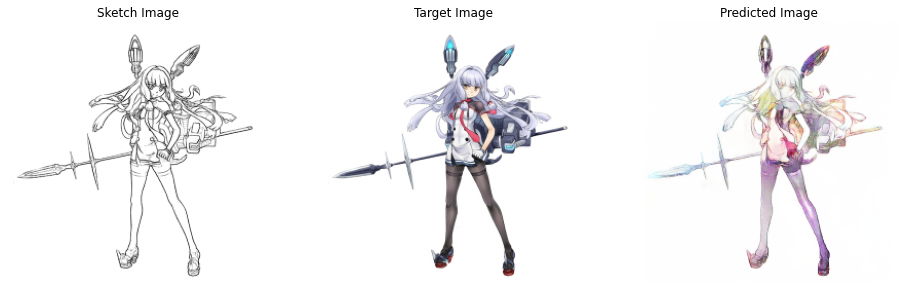

Epoch:  26


100%|██████████| 2849/2849 [01:26<00:00, 32.82it/s]



Generator Loss: 16.06
Discriminator Loss: 0.45



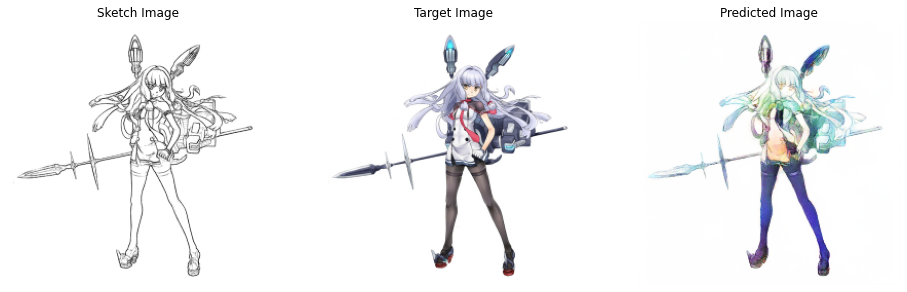

Epoch:  27


100%|██████████| 2849/2849 [01:28<00:00, 32.28it/s]



Generator Loss: 15.95
Discriminator Loss: 0.45



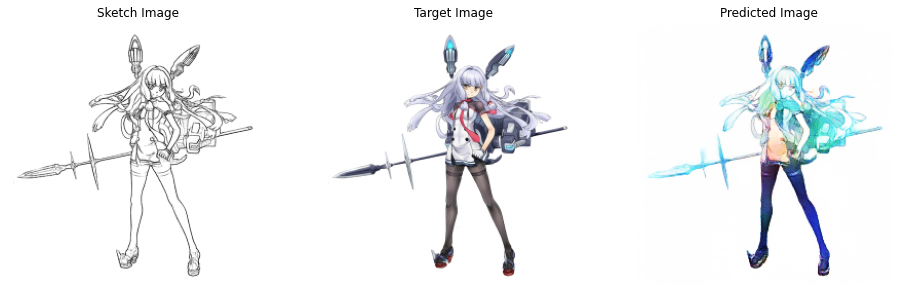

Epoch:  28


100%|██████████| 2849/2849 [01:27<00:00, 32.49it/s]



Generator Loss: 15.92
Discriminator Loss: 0.44



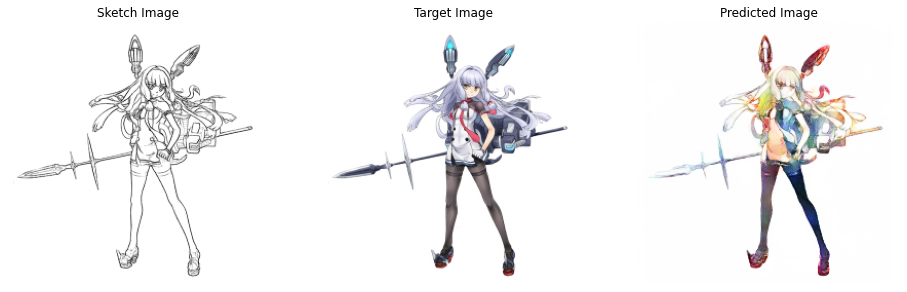

Epoch:  29


100%|██████████| 2849/2849 [01:28<00:00, 32.35it/s]



Generator Loss: 15.82
Discriminator Loss: 0.45



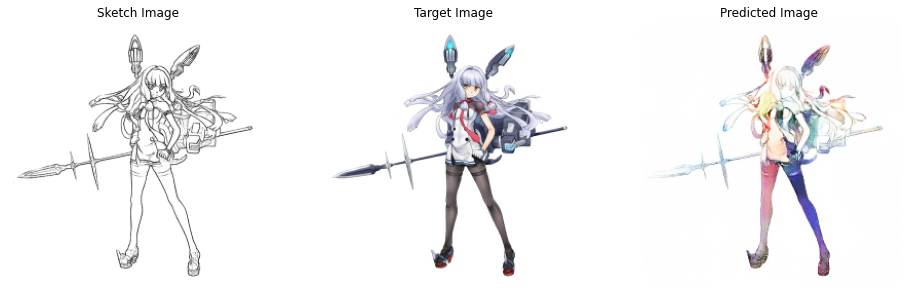

Epoch:  30


100%|██████████| 2849/2849 [01:27<00:00, 32.65it/s]


Generator Loss: 15.79
Discriminator Loss: 0.42



In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(1, epochs+1):
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)
        
        for n, (sketch_image, colored_image) in tqdm(train_ds.enumerate()):
            g_loss, d_loss = train_step(sketch_image, colored_image, epoch)
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
             
        print("\nGenerator Loss: %.2f" % epoch_loss_avg_gen.result().numpy())
        print("Discriminator Loss: %.2f\n" % epoch_loss_avg_disc.result().numpy())
        
        generator_mean_losses.append(epoch_loss_avg_gen.result().numpy())
        discriminator_mean_losses.append(epoch_loss_avg_disc.result().numpy())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()


fit(train_dataset, epochs, test_dataset)

Discriminator loss

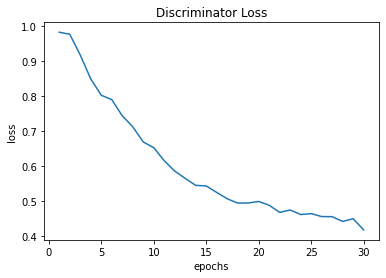

In [ ]:
plt.plot(range(1,epochs+1), discriminator_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Discriminator Loss')
plt.show()

Generator loss

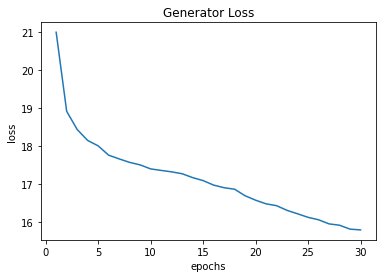

In [ ]:
plt.plot(range(1,epochs+1), generator_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Generator Loss')
plt.show()

Testing model

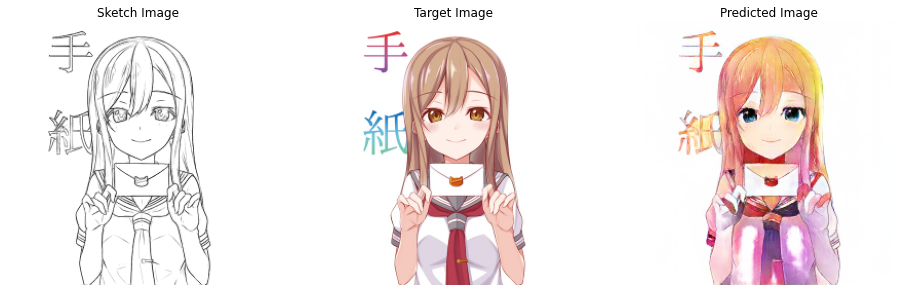

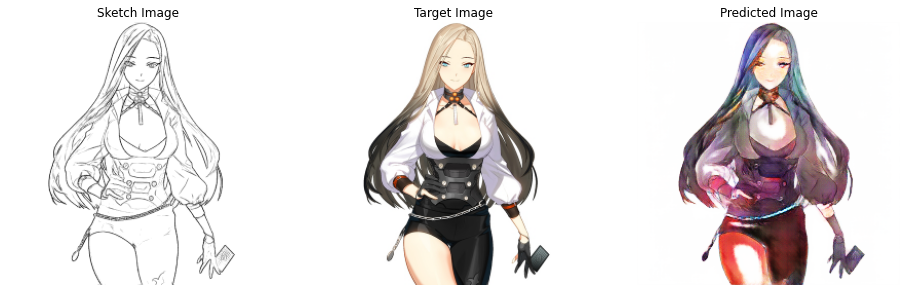

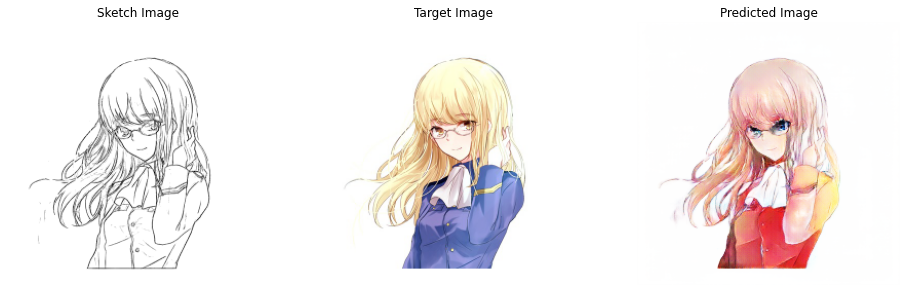

In [ ]:
for n, data in enumerate(test_dataset):
    if(n>321 and n<325):
        sketch_image = data[0]
        ground_truth = data[1]
        generate_images(generator, sketch_image, ground_truth)
    elif (n>500):
        break